In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wordcloud
!pip install matplotlib
!pip install konlpy
!pip install gensim
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from konlpy.tag import Okt
import gensim
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
news_noun=pd.read_csv("/content/drive/MyDrive/관세청공모전/크롤링데이터/news_noun.csv")

In [ ]:
news_noun.head()

,title,raw_text,date,url,processed_text,nouns_only,filtered_nouns_only
0,"""KC인증이 능사 아냐…계속 모니터링 해야""[中직구 안전성 논란④]","""KC인증이 능사 아냐…계속 모니터링 해야""[中직구 안전성 논란④] ""발암물질 및...",2024-06-03,https://www.newsis.com/view/?id=NISX20240531_0...,"['KC', '인증', '능사', '아냐', '계속', '모니터링', '해야', '...",인증 능사 계속 모니터링 직구 안전성 논란 발암 물질 유해 물질 검 문제 반복 발생...,인증 능사 계속 모니터링 직구 안전성 논란 발암 물질 유해 물질 문제 반복 발생 사...
1,"'직구 금지' 철회한 정부, 유해물품 안전성 검증할 방법은 - 머니S",최근 정부가 해외 직구 규제 대책을 발표했다가 번복하면서 소비자 혼란이 가중되고 있...,2024-06-03,https://www.moneys.co.kr/article/2024053117523...,"['최근', '정부', '해외', '직구', '규제', '대책', '발표', '했다...",최근 정부 해외 직구 규제 대책 발표 번복 소비자 혼란 가중 해외 직구 국가 통합인...,최근 정부 해외 직구 규제 대책 발표 번복 소비자 혼란 가중 해외 직구 국가 통합인...
2,[테크왔숑] 늘어나는 해외직구에 신용카드 해킹 피해 급증···VPN으로 이중잠금,노드VPN의 다크 웹 모니터링·Double VPN 기능 통해 개인 정보 보호 철저 ...,2024-06-03,https://www.cnet.co.kr/view/?no=20240603113543,"['노드', 'VPN', '다크', '웹', '모니터링', 'Double', 'VP...",노드 다크 웹 모니터링 기능 통해 개인 정보 보호 철저 씨넷 코리아 황진영 금융감독...,노드 다크 모니터링 기능 통해 개인 정보 보호 철저 씨넷 코리아 황진영 금융감독원 ...
3,"짝퉁 골프, 중국계 플랫폼 중고 시장서 활개","가품 골프용품 거래 현장 [자료=클럽하우스] \n 알리, 테무, 쉬인 등 최근 급...",2024-06-04,http://jtbcgolf.joins.com/news/news_view.asp?n...,"['가품', '골프', '용품', '거래', '현장', '자료', '클럽', '하우...",가품 골프 용품 거래 현장 자료 클럽 하우스 알리 테무 쉬 인 최근 급성 장 중국 ...,가품 골프 용품 거래 현장 자료 클럽 하우스 알리 테무 최근 급성 중국 유통 플랫폼...
4,中 초저가 직구 급증…항공운임도 고공행진,中 초저가 직구 급증…항공운임도 고공행진 3·4분기 해상화물 몰려 더 뛸 듯 2일...,2024-06-02,https://www.hankyung.com/article/2024060299621,"['中', '초', '저가', '직구', '급증', '항공', '운임', '도', ...",초 저가 직구 급증 항공 운임 도 고공 행진 분기 해상 화물 더 듯 항공 업계 지난...,저가 직구 급증 항공 운임 고공 행진 분기 해상 화물 항공 업계 지난 기준 홍콩 북...


In [ ]:
# 모든 기사 텍스트에서 명사만 추출하여 리스트에 저장
# all_nouns = []
# for text_list in ['processed_text']:  # 모든 기사에 대해
#     nouns = okt.nouns(text_list)  # 명사만 추출
#     all_nouns.extend(nouns)  # 명사를 리스트에 추가


In [ ]:
# # 길이가 1보다 큰 명사만 필터링
# filtered_nouns = [noun for noun in all_nouns if len(noun) > 1]

# # 명사 빈도수 계산
# noun_counts = Counter(filtered_nouns)

In [ ]:
# 'filtered_nouns_only' 열의 데이터 타입을 확인합니다.
column_data_type = news_noun['filtered_nouns_only'].dtype

# 데이터 타입을 출력합니다.
print("데이터 타입:", column_data_type)

데이터 타입: object


In [ ]:
news_noun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                4743 non-null   object
 1   raw_text             4743 non-null   object
 2   date                 4743 non-null   object
 3   url                  4743 non-null   object
 4   processed_text       4743 non-null   object
 5   nouns_only           4710 non-null   object
 6   filtered_nouns_only  4708 non-null   object
dtypes: object(7)
memory usage: 259.5+ KB


In [ ]:
# 하나라도 NaN 값을 가지는 행을 뽑아내기
rows_with_nan = news_noun[news_noun.isna().any(axis=1)]

# 결과를 출력합니다.
print(rows_with_nan)

                                                  title  \
69            咯沸傈俊 剐赴 '流备措氓'ˇ耖 舅府·抛公 力前 技陛 给 叭唱 - 赣聪捧单捞   
159        KC牢刘 绝绰 吝惫魂 力前 流备 陛瘤ˇ啊前·蜡秦 力前 烹包辑 瞒窜 - 赣聪捧单捞   
207                      'KC 牢刘' 绝绰 吝惫魂, 流备 给茄促 - 赣聪捧单捞   
217          "KC牢刘 绝绢档 秦寇流备 啊瓷ˇ陛瘤 前格档 困秦己 炼荤何磐" - 赣聪捧单捞   
303   ЧиПмСїБИ БнСі БдСІДТ УЖШИЧпСіИИЁІ ЁАУпАЁ ОШРќД...   
350   [ьЖМьЕЬ] ьВмэЪМуЕгьдСъ╡н эХ┤ьЩ╕ьзБъ╡м эФМыЮлэП...   
377        妯 寸鼻林磊甸, 沥何 '流备 痹力' 菊促琵 厚魄ˇ茄悼绕档 魔宫 柄 - 赣聪捧单捞   
619    ЁЎОШСЄМК ГэЖѕЁЏ ЧиПмСїБИЁІБЙГЛЙнРд БтСиЁЄР§Тї АШ   
767   СпБЙ СїБИ ПЧГ, БлЗЮЙњ eФПИгНК НУРх АГЦэ НХШЃХК...   
843         И№ЙйРЯОл ЦЎЗЛЕхЁІИЎПіЕх, МєЦћ, ёщСїБИЧУЗЇЦћ   
970          АјЗц ЧУЗЇЦћЁЄCФПИгНКЁІШчЕщИЎДТ БЙГЛ РЏХыАЁ   
990   ёщ СїБИ БоСѕЧЯРкЁІСЄКЮ, ОЫИЎЁЄХзЙЋ Ею ЁЎБЙГЛ Д...   
1005      ёщ СїБИАХЗЁОз 1ГтИИПЁ 2Йш СѕАЁЁІкИ СІФЁАэ 1РЇ   
1028  [�ڽ����� ���̳� ��Ŀ��(33)] �߱� ���� �÷��� ���밭�...   
1051  СпБЙ МюЧЮИє ЁЎОЫЁЄХзЁЄНЌЁЏ ОЦЕППыЧАПЁМЕЕ ЙпОЯЙ...   
1056  СпБЙ МюЧЮИєМ Лъ АЁЙцПЁ ЙпОЯЙАСњРЬЁІМПяНУ ЛѓНУ ... 

In [ ]:
#하나라도 NaN 있는 데이터 행 모두 제거
news_noun = news_noun.dropna(how='any')

In [ ]:
drive_path = '/content/drive/MyDrive/관세청공모전/크롤링데이터'  # 실제 경로로 변경
cleaned_csv_path = os.path.join(drive_path, 'news_전처리찐최종.csv')
news_noun.to_csv(cleaned_csv_path, index=False)

In [ ]:
news=pd.read_csv("/content/drive/MyDrive/관세청공모전/크롤링데이터/news_전처리찐최종.csv")

In [ ]:
news.head()

,title,raw_text,date,url,processed_text,nouns_only,filtered_nouns_only,word_list
0,"""KC인증이 능사 아냐…계속 모니터링 해야""[中직구 안전성 논란④]","""KC인증이 능사 아냐…계속 모니터링 해야""[中직구 안전성 논란④] ""발암물질 및...",2024-06-03,https://www.newsis.com/view/?id=NISX20240531_0...,"['KC', '인증', '능사', '아냐', '계속', '모니터링', '해야', '...",인증 능사 계속 모니터링 직구 안전성 논란 발암 물질 유해 물질 검 문제 반복 발생...,인증 능사 계속 모니터링 직구 안전성 논란 발암 물질 유해 물질 문제 반복 발생 사...,"['인증', '능사', '계속', '모니터링', '직구', '안전성', '논란', ..."
1,"'직구 금지' 철회한 정부, 유해물품 안전성 검증할 방법은 - 머니S",최근 정부가 해외 직구 규제 대책을 발표했다가 번복하면서 소비자 혼란이 가중되고 있...,2024-06-03,https://www.moneys.co.kr/article/2024053117523...,"['최근', '정부', '해외', '직구', '규제', '대책', '발표', '했다...",최근 정부 해외 직구 규제 대책 발표 번복 소비자 혼란 가중 해외 직구 국가 통합인...,정부 해외 직구 규제 대책 발표 번복 소비자 혼란 가중 해외 직구 국가 통합인증 마...,"['최근', '정부', '해외', '직구', '규제', '대책', '발표', '번복..."
2,[테크왔숑] 늘어나는 해외직구에 신용카드 해킹 피해 급증···VPN으로 이중잠금,노드VPN의 다크 웹 모니터링·Double VPN 기능 통해 개인 정보 보호 철저 ...,2024-06-03,https://www.cnet.co.kr/view/?no=20240603113543,"['노드', 'VPN', '다크', '웹', '모니터링', 'Double', 'VP...",노드 다크 웹 모니터링 기능 통해 개인 정보 보호 철저 씨넷 코리아 황진영 금융감독...,노드 다크 모니터링 기능 개인 정보 보호 철저 씨넷 코리아 황진영 금융감독원 피싱 ...,"['노드', '다크', '모니터링', '기능', '통해', '개인', '정보', '..."
3,"짝퉁 골프, 중국계 플랫폼 중고 시장서 활개","가품 골프용품 거래 현장 [자료=클럽하우스] \n 알리, 테무, 쉬인 등 최근 급...",2024-06-04,http://jtbcgolf.joins.com/news/news_view.asp?n...,"['가품', '골프', '용품', '거래', '현장', '자료', '클럽', '하우...",가품 골프 용품 거래 현장 자료 클럽 하우스 알리 테무 쉬 인 최근 급성 장 중국 ...,가품 골프 용품 거래 현장 자료 클럽 하우스 알리 테무 급성 중국 유통 플랫폼 중고...,"['가품', '골프', '용품', '거래', '현장', '자료', '클럽', '하우..."
4,中 초저가 직구 급증…항공운임도 고공행진,中 초저가 직구 급증…항공운임도 고공행진 3·4분기 해상화물 몰려 더 뛸 듯 2일...,2024-06-02,https://www.hankyung.com/article/2024060299621,"['中', '초', '저가', '직구', '급증', '항공', '운임', '도', ...",초 저가 직구 급증 항공 운임 도 고공 행진 분기 해상 화물 더 듯 항공 업계 지난...,저가 직구 급증 항공 운임 고공 행진 해상 화물 항공 업계 기준 홍콩 북미 노선 화...,"['저가', '직구', '급증', '항공', '운임', '고공', '행진', '분기..."


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                4704 non-null   object
 1   raw_text             4704 non-null   object
 2   date                 4704 non-null   object
 3   url                  4704 non-null   object
 4   processed_text       4704 non-null   object
 5   nouns_only           4704 non-null   object
 6   filtered_nouns_only  4704 non-null   object
 7   word_list            4704 non-null   object
dtypes: object(8)
memory usage: 294.1+ KB


In [ ]:
# 'filtered_nouns_only' 열에서 모든 명사를 추출하여 리스트로 만듭니다.
all_nouns = ' '.join(news['filtered_nouns_only']).split()

# 명사 빈도를 계산합니다.
noun_counts = Counter(all_nouns)

# 상위 10개의 명사와 그 빈도를 출력합니다.
print(noun_counts.most_common(10))

[('중국', 24238), ('직구', 18206), ('국내', 16537), ('해외', 14817), ('제품', 14112), ('알리', 13109), ('플랫폼', 11942), ('시장', 11069), ('소비자', 10915), ('이커머스', 10906)]


In [ ]:
import numpy as np
from PIL import Image,ImageFilter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
mask_3=Image.open("/content/drive/MyDrive/관세청공모전/관세청 심볼02.png")
mask_3 = mask_3.filter(ImageFilter.GaussianBlur(5))  # 블러 처리하여 가장자리를 부드럽게 만듭니다
mask_3 = np.array(mask_3)

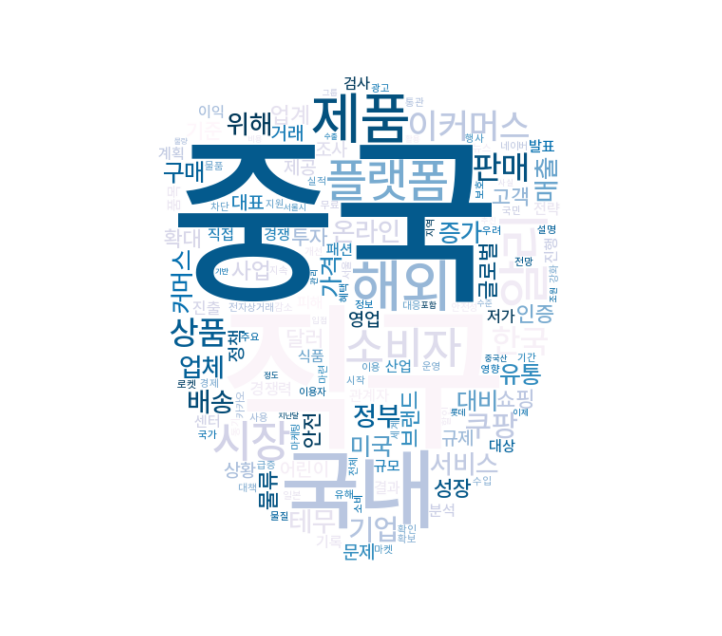

In [ ]:
wordcloud = WordCloud(font_path="/content/drive/MyDrive/크롤링/Pretendard-Medium.ttf",
                      background_color='white',
                      mask=mask_3,
                      width=400,
                      height=450,
                      colormap='PuBu',
                      # contour_width=1,
                      # contour_color='navy',
                      random_state = 20,
                      max_words = 150).generate_from_frequencies(noun_counts)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()